In [1]:
from kaggle.api.kaggle_api_extended import KaggleApi
import pandas as pd
import numpy as np
import mlcroissant as mlc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import json
import os
import re

In [2]:
os.environ['KAGGLE_CONFIG_DIR'] = '/Users/veronhoxha/.kaggle'

kaggle_username = os.getenv('KAGGLE_USERNAME')
kaggle_key = os.getenv('KAGGLE_KEY')

In [3]:
api = KaggleApi()
api.authenticate()

### Number of total datasets with word "ISIC" in the title in Kaggle

In [4]:
search_term = 'ISIC'
datasets_list = []
page = 1

while True:
    datasets = api.dataset_list(search=search_term, page=page)
    if not datasets:
        break
    for dataset in datasets:
        if search_term.lower() in dataset.title.lower():
            datasets_list.append(dataset)
    page += 1

print(f"Total datasets found with 'ISIC' in the title: {len(datasets_list)}")

Total datasets found with 'ISIC' in the title: 871


In [5]:
# converting all sizes to bytes

def parse_size(size_str):
    size_str = size_str.strip()
    size_regex = r'([\d\.]+)\s*([KMGT]?B)'
    match = re.match(size_regex, size_str, re.IGNORECASE)
    if not match:
        return None, None
    size_value, unit = match.groups()
    size_value = float(size_value)
    unit = unit.upper()
    units = {
        'B': 1,
        'KB': 1024,
        'MB': 1024 ** 2,
        'GB': 1024 ** 3,
        'TB': 1024 ** 4,
    }
    size_in_bytes = size_value * units.get(unit, 1)
    
    return size_in_bytes, unit

In [6]:
# flatting metadata since we are working with nested dictionary and list 

def flatten_metadata(metadata, parent_key='', sep='.'):
    items = []
    for k, v in metadata.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_metadata(v, new_key, sep=sep).items())
        elif isinstance(v, list):
            if all(isinstance(i, dict) for i in v):
                for idx, item in enumerate(v):
                    items.extend(flatten_metadata(item, f"{new_key}_{idx}", sep=sep).items())
            else:
                items.append((new_key, '; '.join(map(str, v))))
        else:
            items.append((new_key, v))
    return dict(items)

In [7]:
# collecting metadata

def convert_dataset_to_croissant(dataset):
    if dataset.tags:
        keywords = [tag.name for tag in dataset.tags]
    else:
        keywords = []
    
    # parsing the dataset.size
    size_in_bytes = None
    if dataset.size:
        try:
            size_in_bytes = float(dataset.size)
        except ValueError:
            size_in_bytes, size_unit = parse_size(dataset.size)
        except TypeError:
            size_in_bytes = None
    else:
        size_in_bytes = None
    
    # converting the size to MB
    if size_in_bytes:
        content_size_mb = size_in_bytes / (1024 * 1024)
        content_size_str = f"{content_size_mb}"
    else:
        content_size_str = "Unknown"
    
    owner_username = dataset.ref.split('/')[0]
    
    croissant_metadata = {
        "@context": {
            "@language": "en",
            "@vocab": "https://schema.org/",
            # there is a lot of other metadata here but i dont need them for now at least
        },
        "@type": "Dataset",
        "name": dataset.title,
        "alternateName": dataset.subtitle if dataset.subtitle else '',
        "description": dataset.description if dataset.description else '',
        "url": f"https://www.kaggle.com/{dataset.ref}",
        "identifier": dataset.id,
        "creator": {
            "@type": "Person",
            "name": dataset.creatorName if dataset.creatorName else owner_username,
            "url": f"https://www.kaggle.com/{owner_username}"
        },
        "license": {
            "@type": "CreativeWork",
            "name": dataset.licenseName
        },
        "keywords": keywords,
        "dateModified": dataset.lastUpdated.isoformat() if dataset.lastUpdated else None,
        "isAccessibleForFree": True,
        "distribution": [
            {
                "@type": "DataDownload",
                "contentUrl": f"https://www.kaggle.com/datasets/{dataset.ref}/download",
                "contentSize": content_size_str,
                "encodingFormat": "application/zip"
            }
        ],
        "isPrivate": dataset.isPrivate,
        "downloadCount": dataset.downloadCount,
        "viewCount": dataset.viewCount,
        "voteCount": dataset.voteCount,
        "usabilityRating": dataset.usabilityRating,
        "conformsTo": "http://mlcommons.org/croissant/1.0"
    }
    return croissant_metadata

In [8]:
croissant_metadata_list = []
for dataset in datasets_list:
    croissant_metadata = convert_dataset_to_croissant(dataset)
    croissant_metadata_list.append(croissant_metadata)

data_rows = []
for metadata in croissant_metadata_list:
    flattened_metadata = flatten_metadata(metadata)
    data_rows.append(flattened_metadata)

df = pd.DataFrame(data_rows)

# renaming some columns for clarity
df.rename(columns={
    'distribution_0.contentSize': 'contentSize',
    'distribution_0.contentUrl': 'contentUrl',
    'distribution_0.encodingFormat': 'encodingFormat'
}, inplace=True)

df.to_csv('../data/01_isic_datasets_metadata.csv', index=False)
print("Metadata saved to '01_isic_datasets_metadata.csv'")

Metadata saved to '01_isic_datasets_metadata.csv'


In [9]:
df = pd.read_csv('../data/01_isic_datasets_metadata.csv')

In [10]:
df

,@context.@language,@context.@vocab,@type,name,alternateName,description,url,identifier,creator.@type,creator.name,...,distribution_0.@type,contentUrl,contentSize,encodingFormat,isPrivate,downloadCount,viewCount,voteCount,usabilityRating,conformsTo
0,en,https://schema.org/,Dataset,Skin Cancer ISIC,The skin cancer data. Contains 9 classes of sk...,NaN,https://www.kaggle.com/nodoubttome/skin-cancer...,319080,Person,Andrey Katanskiy,...,DataDownload,https://www.kaggle.com/datasets/nodoubttome/sk...,2048.0,application/zip,False,15900,129877,216,0.750000,http://mlcommons.org/croissant/1.0
1,en,https://schema.org/,Dataset,All ISIC Data 20240629,All images and metadata in ISIC archive.,NaN,https://www.kaggle.com/tomooinubushi/all-isic-...,5302785,Person,tomoo inubushi,...,DataDownload,https://www.kaggle.com/datasets/tomooinubushi/...,75776.0,application/zip,False,365,3347,55,0.764706,http://mlcommons.org/croissant/1.0
2,en,https://schema.org/,Dataset,ISIC 2020 JPG 256x256 RESIZED,NaN,NaN,https://www.kaggle.com/nischaydnk/isic-2020-jp...,5295545,Person,Nischay Dhankhar,...,DataDownload,https://www.kaggle.com/datasets/nischaydnk/isi...,595.0,application/zip,False,667,1938,48,0.882353,http://mlcommons.org/croissant/1.0
3,en,https://schema.org/,Dataset,ISIC 2019 JPG 224x224 RESIZED,ISIC 2019 resized dataset,NaN,https://www.kaggle.com/nischaydnk/isic-2019-jp...,5295517,Person,Nischay Dhankhar,...,DataDownload,https://www.kaggle.com/datasets/nischaydnk/isi...,355.0,application/zip,False,548,1824,39,0.941176,http://mlcommons.org/croissant/1.0
4,en,https://schema.org/,Dataset,JPEG ISIC 2019 512x512,NaN,NaN,https://www.kaggle.com/cdeotte/jpeg-isic2019-5...,762203,Person,Chris Deotte,...,DataDownload,https://www.kaggle.com/datasets/cdeotte/jpeg-i...,1024.0,application/zip,False,2421,7064,54,0.588235,http://mlcommons.org/croissant/1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
866,en,https://schema.org/,Dataset,data_isic1718,NaN,NaN,https://www.kaggle.com/bugakakak/data-isic1718,4788617,Person,bugakakak,...,DataDownload,https://www.kaggle.com/datasets/bugakakak/data...,261.0,application/zip,False,0,16,0,0.000000,http://mlcommons.org/croissant/1.0
867,en,https://schema.org/,Dataset,siim_isic_2020_leukemia_dataset,NaN,NaN,https://www.kaggle.com/rajibbag1/siim-isic-202...,4911856,Person,RAJIB BAG_1,...,DataDownload,https://www.kaggle.com/datasets/rajibbag1/siim...,2048.0,application/zip,False,0,18,0,0.000000,http://mlcommons.org/croissant/1.0
868,en,https://schema.org/,Dataset,Linear_exact_ISIC_2017_test,NaN,NaN,https://www.kaggle.com/sujansarkar/linear-exac...,3804149,Person,Sujan Sarkar,...,DataDownload,https://www.kaggle.com/datasets/sujansarkar/li...,54.0,application/zip,False,1,39,0,0.000000,http://mlcommons.org/croissant/1.0
869,en,https://schema.org/,Dataset,4000ISIC19Balanced,NaN,NaN,https://www.kaggle.com/manirujjamanmonir/4000i...,3374258,Person,Manirujjaman Monir,...,DataDownload,https://www.kaggle.com/datasets/manirujjamanmo...,6144.0,application/zip,False,2,73,0,0.000000,http://mlcommons.org/croissant/1.0


In [11]:
print(df.columns.tolist())

['@context.@language', '@context.@vocab', '@type', 'name', 'alternateName', 'description', 'url', 'identifier', 'creator.@type', 'creator.name', 'creator.url', 'license.@type', 'license.name', 'keywords', 'dateModified', 'isAccessibleForFree', 'distribution_0.@type', 'contentUrl', 'contentSize', 'encodingFormat', 'isPrivate', 'downloadCount', 'viewCount', 'voteCount', 'usabilityRating', 'conformsTo']


In [12]:
df.name.value_counts()

name
ISIC2018                                6
ISIC2017                                5
Skin Cancer ISIC                        4
isic2018                                4
isic2016                                4
                                       ..
ISIC-2024-train-1954                    1
Melanoma TFRecords 768x768 ISIC 2016    1
Melanoma TFRecords 512x512 ISIC 2016    1
Melanoma TFRecords 384x384 ISIC 2016    1
melanoma_isic                           1
Name: count, Length: 830, dtype: int64

In [13]:
df.description.value_counts()

Series([], Name: count, dtype: int64)

In [14]:
df.isAccessibleForFree.value_counts()

isAccessibleForFree
True    871
Name: count, dtype: int64

In [15]:
df.usabilityRating.value_counts().sort_index()

usabilityRating
0.000000     49
0.062500     19
0.117647    110
0.125000    151
0.176471     36
0.187500     87
0.205882      1
0.235294     67
0.250000     72
0.294118     52
0.312500     54
0.352941     12
0.375000     39
0.411765     15
0.437500     28
0.470588      5
0.500000     11
0.529412      7
0.562500      3
0.588235     17
0.625000      1
0.647059      2
0.687500      4
0.705882      6
0.750000      2
0.764706      3
0.812500      3
0.823529      3
0.875000      3
0.882353      4
0.911765      1
0.941176      1
1.000000      3
Name: count, dtype: int64

In [16]:
df['contentSize'] = df['contentSize'].replace('Unknown', np.nan)
df['contentSize'] = df['contentSize'].astype(float)
df = df.sort_values('contentSize', ascending=False)
df

,@context.@language,@context.@vocab,@type,name,alternateName,description,url,identifier,creator.@type,creator.name,...,distribution_0.@type,contentUrl,contentSize,encodingFormat,isPrivate,downloadCount,viewCount,voteCount,usabilityRating,conformsTo
1,en,https://schema.org/,Dataset,All ISIC Data 20240629,All images and metadata in ISIC archive.,NaN,https://www.kaggle.com/tomooinubushi/all-isic-...,5302785,Person,tomoo inubushi,...,DataDownload,https://www.kaggle.com/datasets/tomooinubushi/...,75776.000000,application/zip,False,365,3347,55,0.764706,http://mlcommons.org/croissant/1.0
804,en,https://schema.org/,Dataset,Augmentation Task ISIC2019,NaN,NaN,https://www.kaggle.com/shaheedanwarfahad/augme...,3947239,Person,Shaheed Anwar Fahad,...,DataDownload,https://www.kaggle.com/datasets/shaheedanwarfa...,52224.000000,application/zip,False,4,295,0,0.125000,http://mlcommons.org/croissant/1.0
662,en,https://schema.org/,Dataset,ISIC2019 Augmented data,NaN,NaN,https://www.kaggle.com/kishorebabunampalle/isi...,3544602,Person,Kishore Babu Nampalle,...,DataDownload,https://www.kaggle.com/datasets/kishorebabunam...,34816.000000,application/zip,False,4,64,0,0.250000,http://mlcommons.org/croissant/1.0
501,en,https://schema.org/,Dataset,ISIC 2020,NaN,NaN,https://www.kaggle.com/shakiburrahmanasif/isic...,4096026,Person,Shakib Ur Rahman Asif,...,DataDownload,https://www.kaggle.com/datasets/shakiburrahman...,32768.000000,application/zip,False,5,103,0,0.000000,http://mlcommons.org/croissant/1.0
57,en,https://schema.org/,Dataset,PyTorch JPEG SIIM-ISIC Melanoma Competition,NaN,NaN,https://www.kaggle.com/whatsthevariance/melano...,778684,Person,Caleb Woy,...,DataDownload,https://www.kaggle.com/datasets/whatsthevarian...,30720.000000,application/zip,False,165,2664,7,0.529412,http://mlcommons.org/croissant/1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555,en,https://schema.org/,Dataset,OneHot Encoder ISIC 2024,NaN,NaN,https://www.kaggle.com/greysky/onehot-encoder-...,5654530,Person,Farukcan Saglam,...,DataDownload,https://www.kaggle.com/datasets/greysky/onehot...,0.000977,application/zip,False,2,4,0,0.062500,http://mlcommons.org/croissant/1.0
640,en,https://schema.org/,Dataset,ISIC 2024 Final Scores for LB 50 to 150,NaN,NaN,https://www.kaggle.com/richolson/isic-2024-fin...,5665881,Person,Rich Olson,...,DataDownload,https://www.kaggle.com/datasets/richolson/isic...,0.000708,application/zip,False,0,8,0,0.352941,http://mlcommons.org/croissant/1.0
28,en,https://schema.org/,Dataset,SIIM-ISIC Melanoma Resized Images,NaN,NaN,https://www.kaggle.com/tunguz/siimisic-melanom...,680899,Person,Bojan Tunguz,...,DataDownload,https://www.kaggle.com/datasets/tunguz/siimisi...,NaN,application/zip,False,311,3654,28,0.187500,http://mlcommons.org/croissant/1.0
356,en,https://schema.org/,Dataset,ISIC 2018,NaN,NaN,https://www.kaggle.com/nhlong12/isic-2018,4676897,Person,Hoang Long Nguyen,...,DataDownload,https://www.kaggle.com/datasets/nhlong12/isic-...,NaN,application/zip,False,1,111,0,0.125000,http://mlcommons.org/croissant/1.0


In [17]:
# datasets with null contentSize
df[df.contentSize.isnull()]


,@context.@language,@context.@vocab,@type,name,alternateName,description,url,identifier,creator.@type,creator.name,...,distribution_0.@type,contentUrl,contentSize,encodingFormat,isPrivate,downloadCount,viewCount,voteCount,usabilityRating,conformsTo
28,en,https://schema.org/,Dataset,SIIM-ISIC Melanoma Resized Images,NaN,NaN,https://www.kaggle.com/tunguz/siimisic-melanom...,680899,Person,Bojan Tunguz,...,DataDownload,https://www.kaggle.com/datasets/tunguz/siimisi...,NaN,application/zip,False,311,3654,28,0.1875,http://mlcommons.org/croissant/1.0
356,en,https://schema.org/,Dataset,ISIC 2018,NaN,NaN,https://www.kaggle.com/nhlong12/isic-2018,4676897,Person,Hoang Long Nguyen,...,DataDownload,https://www.kaggle.com/datasets/nhlong12/isic-...,NaN,application/zip,False,1,111,0,0.1250,http://mlcommons.org/croissant/1.0
696,en,https://schema.org/,Dataset,ISIC_Minimal_Data,NaN,NaN,https://www.kaggle.com/segijaganath/isic-minim...,4654435,Person,Segi Jaganath,...,DataDownload,https://www.kaggle.com/datasets/segijaganath/i...,NaN,application/zip,False,0,18,0,0.1250,http://mlcommons.org/croissant/1.0


In [18]:
# top 5 datasets with the largest contentSize that is not null
df[df.contentSize.notnull()].sort_values('contentSize', ascending=False).head(5)

,@context.@language,@context.@vocab,@type,name,alternateName,description,url,identifier,creator.@type,creator.name,...,distribution_0.@type,contentUrl,contentSize,encodingFormat,isPrivate,downloadCount,viewCount,voteCount,usabilityRating,conformsTo
1,en,https://schema.org/,Dataset,All ISIC Data 20240629,All images and metadata in ISIC archive.,NaN,https://www.kaggle.com/tomooinubushi/all-isic-...,5302785,Person,tomoo inubushi,...,DataDownload,https://www.kaggle.com/datasets/tomooinubushi/...,75776.0,application/zip,False,365,3347,55,0.764706,http://mlcommons.org/croissant/1.0
804,en,https://schema.org/,Dataset,Augmentation Task ISIC2019,NaN,NaN,https://www.kaggle.com/shaheedanwarfahad/augme...,3947239,Person,Shaheed Anwar Fahad,...,DataDownload,https://www.kaggle.com/datasets/shaheedanwarfa...,52224.0,application/zip,False,4,295,0,0.125000,http://mlcommons.org/croissant/1.0
662,en,https://schema.org/,Dataset,ISIC2019 Augmented data,NaN,NaN,https://www.kaggle.com/kishorebabunampalle/isi...,3544602,Person,Kishore Babu Nampalle,...,DataDownload,https://www.kaggle.com/datasets/kishorebabunam...,34816.0,application/zip,False,4,64,0,0.250000,http://mlcommons.org/croissant/1.0
501,en,https://schema.org/,Dataset,ISIC 2020,NaN,NaN,https://www.kaggle.com/shakiburrahmanasif/isic...,4096026,Person,Shakib Ur Rahman Asif,...,DataDownload,https://www.kaggle.com/datasets/shakiburrahman...,32768.0,application/zip,False,5,103,0,0.000000,http://mlcommons.org/croissant/1.0
57,en,https://schema.org/,Dataset,PyTorch JPEG SIIM-ISIC Melanoma Competition,NaN,NaN,https://www.kaggle.com/whatsthevariance/melano...,778684,Person,Caleb Woy,...,DataDownload,https://www.kaggle.com/datasets/whatsthevarian...,30720.0,application/zip,False,165,2664,7,0.529412,http://mlcommons.org/croissant/1.0


In [19]:
df.contentSize.isnull().sum()

np.int64(3)

In [20]:
df.usabilityRating.isnull().sum() 

np.int64(0)

In [21]:
df.downloadCount.isnull().sum()

np.int64(0)

In [22]:
df = df.dropna(subset=['contentSize'])
df = df.dropna(subset=['usabilityRating'])
df = df.dropna(subset=['downloadCount'])
df.drop(df[df.contentSize == 'Unknown'].index, inplace=True)

## Line plot of number of dataset modifications over years

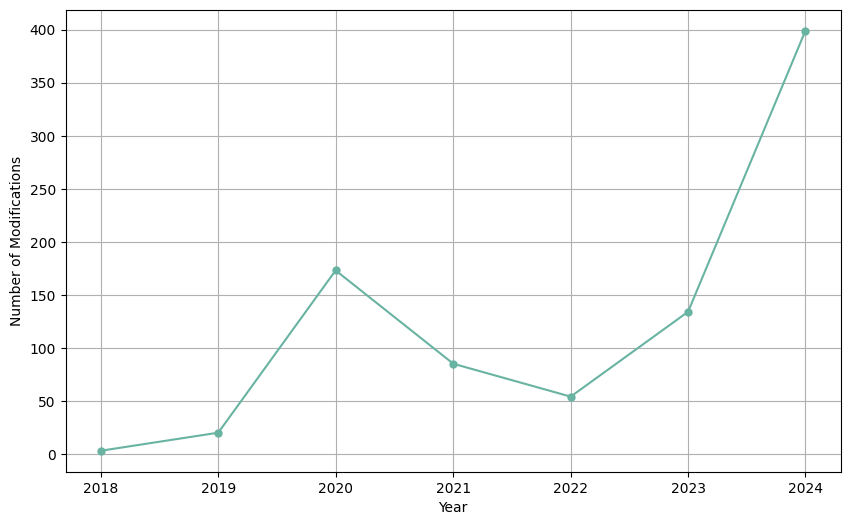

In [35]:
df['dateModified'] = pd.to_datetime(df['dateModified'])

df['Period'] = df['dateModified'].dt.to_period("Y")

modification_counts = df.groupby('Period').size()

plt.figure(figsize=(10, 6))
plt.plot(modification_counts.index.to_timestamp(), modification_counts, marker='o', markersize=5, color='#69b3a2')
plt.xlabel("Year")
plt.ylabel("Number of Modifications")
# plt.title("Number of Dataset Modifications Over Time")
plt.grid(True)
plt.show()

## Scatter plots to identify if there is any correlational relationships between contentSize VS downloadCount and contentSize VS usabilityRating

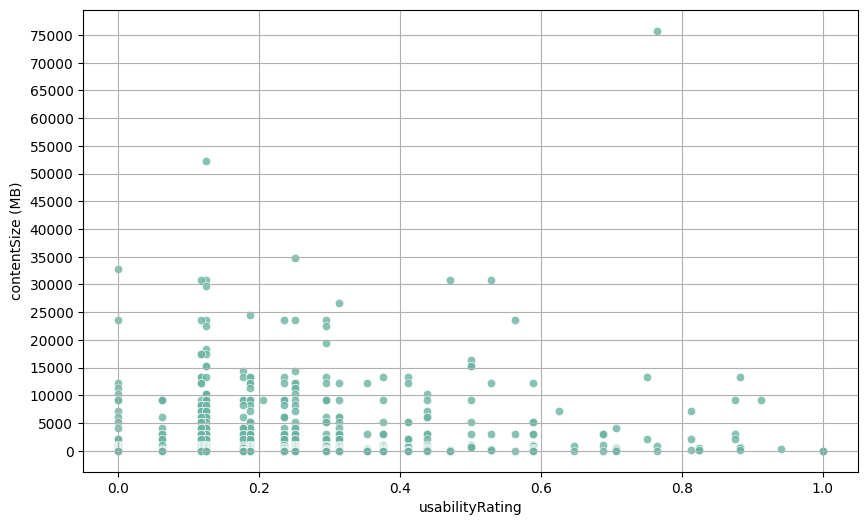

In [24]:
df.sort_values(by="contentSize", ascending=False, inplace=True)

plt.figure(figsize=(10,6))

ax = sns.scatterplot(data=df, x='usabilityRating', y='contentSize', c='#69b3a2', alpha=0.8)

plt.xlabel('usabilityRating')
plt.ylabel('contentSize (MB)')

ax.grid(True)

ax.yaxis.set_major_locator(ticker.MultipleLocator(5000))

plt.show()

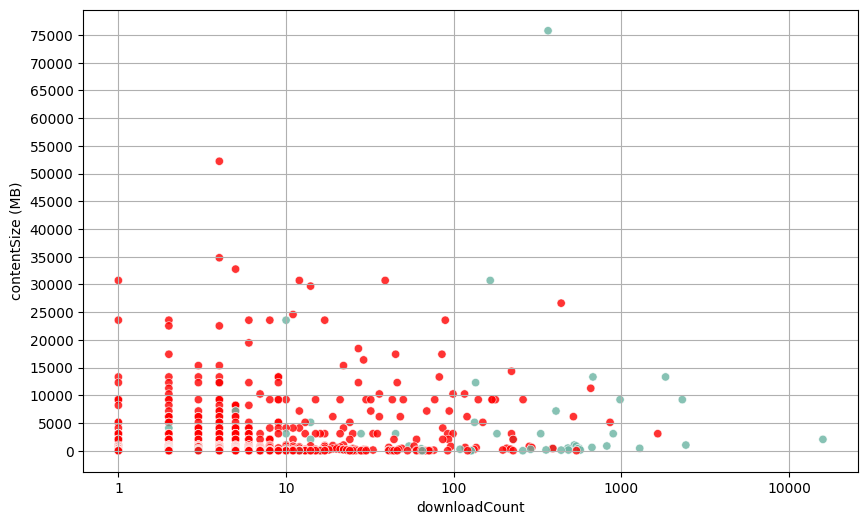

In [25]:
plt.figure(figsize=(10,6))

color = np.where(df['usabilityRating'] > 0.5, '#69b3a2', 'red')

ax = sns.scatterplot(data=df, x='downloadCount', y='contentSize', color=color, alpha=0.8)

plt.xlabel('downloadCount')
plt.ylabel('contentSize (MB)')

ax.set_xscale('log')
ax.grid(True)

ax.xaxis.set_major_locator(ticker.LogLocator(base=10))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.xaxis.set_minor_locator(ticker.NullLocator())
ax.yaxis.set_major_locator(ticker.MultipleLocator(5000))

plt.show()